math_op.py: module Numba is not installed. Install it if you want speed up correlation calculations


[INFO    ] : : beam.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] : : : : : : : : high_order.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] radiation_py.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] radiation_py.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] csr.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] csr.py: module PYFFTW is not installed. Install it to speed up calculation.
[INFO    ] csr.py: module NUMEXPR is not installed. Install it to speed up calculation
[INFO    ] wake3D.py: module NUMBA is not installed. Install it to speed up calculation


initializing ocelot...
import: module NUMBA is not installed. Install it to speed up calculation
import: module PYFFTW is not installed. Install it to speed up calculation
import: module NUMEXPR is not installed. Install it to speed up calculation


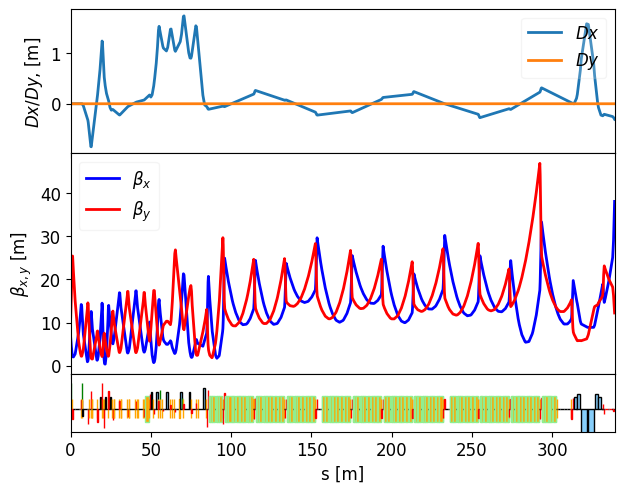

In [1]:
import sys
sys.path.append('/Users/iagapov/workspace/ocelot.2024/ocelot')
#sys.path.append('/Users/iagapov/workspace/ocelot')
from ocelot import *
from ocelot.cpbd.elements import *

from ocelot.gui.accelerator import *

from utils import trunc_s, show_parameter_evolution

#from linac_btp_p1 import *
#from linac_btp import *
from test_optics import *

# 1250 - after linac
# 1350 - after second chicane
# 1600 - before the second arc
lat = MagneticLattice(lattice_list[0:1350])  
#lat = MagneticLattice(lattice_list)

#AX =2.7906447390331426 BX =6.776927886467602    PSIX =56.49535868579681  AY =-5.526446108975507
#           BY =10.553017034834932   PSIY =44.56549637932061  EX =.027326899999999998  EPX =-.005690000000000001     EY =-.0159411
#           EPY =-.0084628 DX =-1.6293750997286722e-15   DPX =1.163621669096704e-15    DZ =-1.3638179127695162e-15   
#           DP =.00055     EMITX =3.09988e-08  EMITY =3.0999e-11

energy = 1.1 # GeV 

tw0 = Twiss()
tw0.alpha_x = 2.8
tw0.beta_x = 6.777

tw0.alpha_y = -5.526
tw0.beta_y = 10.553
tw0.E = energy
tw0.emit_xn = 3.e-8 * energy / 0.511e-3
tw0.emit_yn = 3.e-11 * energy / 0.511e-3
tw0.emit_x = 3.e-8 
tw0.emit_y = 3.e-11

tws = twiss(lat,tw0)

plot_opt_func(lat, tws,legend=False, grid=False, top_plot=['Dx','Dy'])

In [2]:
# tracking
nparticles=100000
p_array=ParticleArray(n=nparticles)


sigma_tau = 6.7e-3 # mm
sigma_p = 5.e-4

p_array.E = energy # GeV
p_array.rparticles[0] = np.zeros(nparticles)
p_array.rparticles[1] = np.zeros(nparticles)
p_array.rparticles[2] = np.zeros(nparticles)
p_array.rparticles[3] = np.zeros(nparticles)
p_array.rparticles[4] = np.random.randn(nparticles) * sigma_tau
p_array.rparticles[5] = np.random.randn(nparticles) * sigma_p

charge = 2.0e-9 # 2 nC

p_array.q_array = np.ones(nparticles) * charge / nparticles

for i in range(nparticles):
    p_array.rparticles[0][i], p_array.rparticles[1][i] = gauss_from_twiss(tw0.emit_x,tw0.beta_x, tw0.alpha_x )
    p_array.rparticles[2][i], p_array.rparticles[3][i] = gauss_from_twiss(tw0.emit_y,tw0.beta_y, tw0.alpha_y )


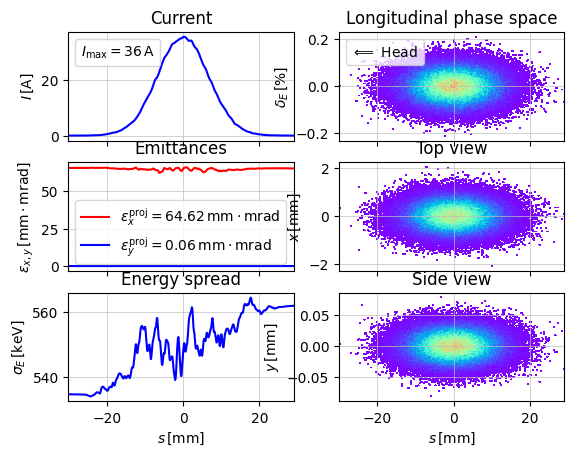

In [3]:
show_e_beam(p_array)

In [4]:
import time
navi = Navigator(lat)
navi.unit_step = 0.1 # m, only with CSR

csr = CSR(n_bin=500, m_bin=5, sigma_min=.2e-6)

#navi.add_physics_proc(csr, cstart, cend)

p_array_t = deepcopy(p_array)
start = time.time()
tws_track, p_array_t = track(lat, p_array_t, navi)
print("\n time exec:", time.time() - start, "sec")

z = 338.81471442402903 / 338.8147144240294. Applied: 
 time exec: 13.992481708526611 sec


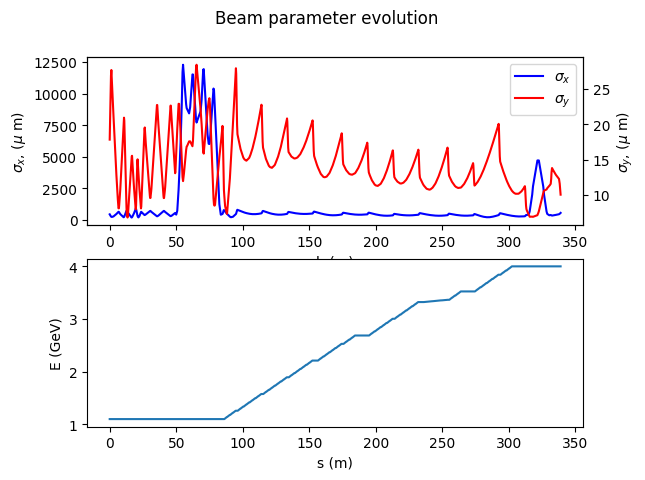

In [5]:
show_parameter_evolution(tws_track)

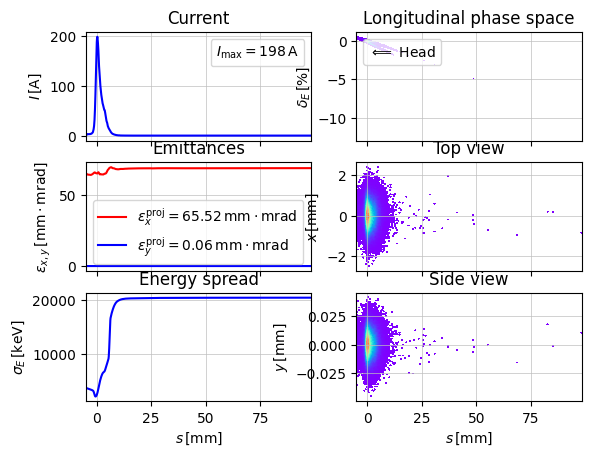

In [6]:
# make two celss: first for first part w/0 CSR
# second for second part with CSR (create/check full optics first)

show_e_beam(p_array_t)


In [7]:
p_array_new = trunc_s(p_array_t, 20.e-3)

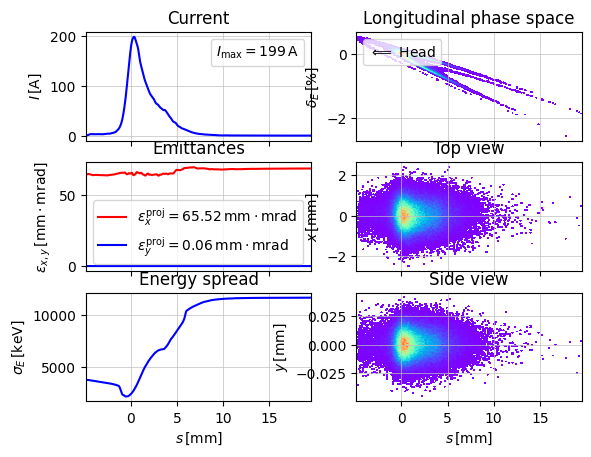

In [8]:
show_e_beam(p_array_new)

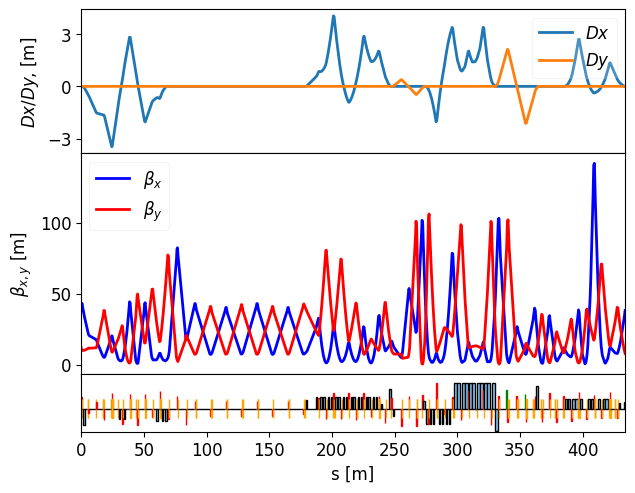

In [9]:
# continue

lat_n = MagneticLattice(lattice_list[1350:-1])  

energy = tws[-1].E # GeV 

tw0_n = Twiss()
tw0_n.alpha_x = tws[-1].alpha_x
tw0_n.beta_x = tws[-1].beta_x

tw0_n.alpha_y = tws[-1].alpha_y
tw0_n.beta_y = tws[-1].beta_y
tw0_n.E = energy

#tw0.emit_xn = 3.e-8 * energy / 0.511e-3
#tw0.emit_yn = 3.e-11 * energy / 0.511e-3
#tw0.emit_x = 3.e-8 
#tw0.emit_y = 3.e-11

tws_n = twiss(lat_n,tw0_n)

plot_opt_func(lat_n, tws_n,legend=False, grid=False, top_plot=['Dx','Dy'])

In [10]:
navi_n = Navigator(lat_n)
navi_n.unit_step = 0.1 # m, only with CSR

csr = CSR(n_bin=500, m_bin=5, sigma_min=.2e-6)
navi_n.add_physics_proc(csr, csrm1_start, csrm1_end)

p_array_t_n = deepcopy(p_array_new)
start = time.time()
tws_track, p_array_t_n = track(lat_n, p_array_t_n, navi_n)
print("\n time exec:", time.time() - start, "sec")

[ERROR   ] In arcline: invalid R_vect --> using Drift. You may have attached the same CSR process to both horizontal and vertical bends.  Otherwise, consider using the Runge-Kutta integrator. (high_order.py:1531)
[ERROR   ] In arcline: invalid R_vect --> using Drift. You may have attached the same CSR process to both horizontal and vertical bends.  Otherwise, consider using the Runge-Kutta integrator. (high_order.py:1531)
[ERROR   ] In arcline: invalid R_vect --> using Drift. You may have attached the same CSR process to both horizontal and vertical bends.  Otherwise, consider using the Runge-Kutta integrator. (high_order.py:1531)
[ERROR   ] In arcline: invalid R_vect --> using Drift. You may have attached the same CSR process to both horizontal and vertical bends.  Otherwise, consider using the Runge-Kutta integrator. (high_order.py:1531)
[ERROR   ] In arcline: invalid R_vect --> using Drift. You may have attached the same CSR process to both horizontal and vertical bends.  Otherwise,



















z = 433.817767475879 / 433.8177674758794. Applied: : SRR
 time exec: 779.3950860500336 sec


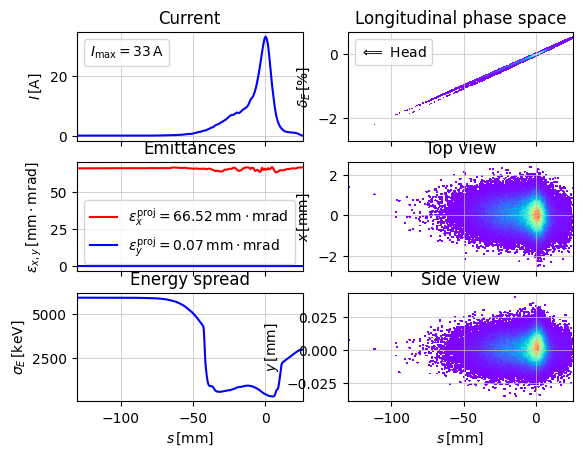

In [11]:
show_e_beam(p_array_t_n)

In [12]:
np.sum(p_array_t_n.q_array)

1.9996e-08

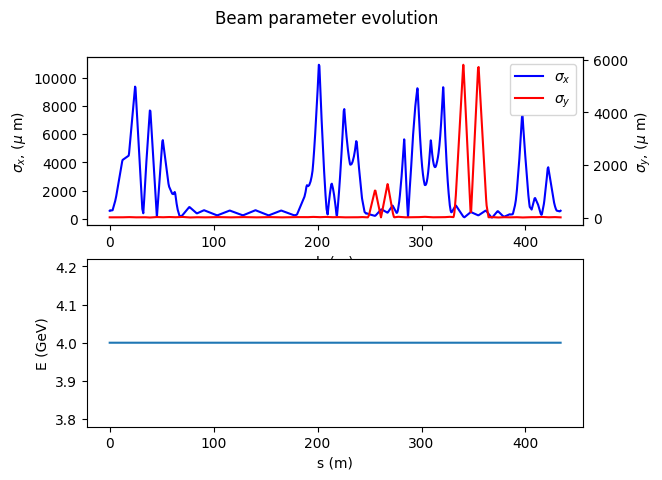

In [12]:
show_parameter_evolution(tws_track)